In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

from spectrum import FitsSpectrum
from common import list_files, list_directories, tqdm

### General functions

In [2]:
dib_centers_all = np.loadtxt('data/dibs_list.csv')
dib_centers_subset = [5780,5797,6196,6379,6613,7224]

def load_target(target_dir: str) -> list[FitsSpectrum]:
    spectra = []

    for band_dir in list_directories(target_dir):
        band_spectra = []

        for datafile in list_files(band_dir):
            if 'BLUE_' in band_dir:
                if len(band_spectra) == 1:
                    break
            elif 'RED_' in band_dir:
                if len(band_spectra) == 2:
                    break

                if len(band_spectra) == 1 and band_spectra[0][-7:] == datafile[-7:]:
                    continue

            band_spectra.append(datafile)

        spectra.extend([FitsSpectrum(sp) for sp in band_spectra])

    return spectra

def fit_gaussian_for_subspectrum(
    subspectrum: FitsSpectrum,
    create_figure = False,
    export_data: list | None = None,
    table_data: list | None = None,
    dib_slice: tuple[int, int] | None = None,
    expected_dib_centers: np.typing.NDArray | None = None,
    tqdm_position: int = 0,
    show_error = False
):
    wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)
    total_latexstr = ''

    subspectrum.remove_outliers()
    subspectrum.correct_shift()

    dibs = list(subspectrum.select_dibs().items())
    dibs_tqdm = tqdm(dibs if dib_slice is None else dibs[dib_slice[0]:dib_slice[1]], position=tqdm_position)
    for center, bounds in dibs_tqdm:
        dibs_tqdm.set_description(f'λ={wvl_min:.2f}-{wvl_max:.2f} [{center:.2f}]')

        # The DIB does not lie in this subspectrum or is not an expected DIB (within 1 angstrom)
        if not wvl_min < center < wvl_max or (expected_dib_centers is not None and np.all(np.abs(expected_dib_centers - center) > 1)):
            continue

        fig, ax = None, None
        if create_figure:
            fig, ax = plt.subplots(1, 1, figsize=(15, 12))

        result = subspectrum.fit_gaussian(center, bounds, ax=ax, show_error=show_error, max_gaussians=3)

        if result is None:
            continue

        if fig is not None:
            fig.savefig(f'export/{subspectrum.target}_{np.round(center).astype(int)}_gauss.pdf')

        params, rmse, r2, fwhm, ew, dib_latexstr = result
        centers, widths, amplitudes, skews = np.column_stack(params)

        total_latexstr += dib_latexstr

        if table_data is not None:
            table_data.append([subspectrum.target, subspectrum.format_obs_date(), bounds[0], bounds[1], *np.column_stack(params), rmse, r2, fwhm, ew])

        if export_data is not None:
            export_data.append('\t'.join([
                subspectrum.obs_date.isoformat(),
                str(bounds[0]), str(bounds[1]),
                np.array2string(centers, separator=','),
                np.array2string(amplitudes, separator=','),
                np.array2string(widths, separator=','),
                np.array2string(skews, separator=','),
                str(rmse), str(r2), str(fwhm), str(ew)
            ]).replace('\n', ' ').replace('\r', ' ').strip())

    return total_latexstr


def fit_gaussian_for_targets(
    targets: list | str,
    expected_dib_centers: np.typing.NDArray | None = None,
    export = False,
    create_figure = False,
    show_error = False
):
    headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'R2', 'FWHM [Å]', 'EW [Å]']
    table_data = []

    if type(targets) == str:
        targets = [targets]

    targets_tqdm = tqdm(targets)
    for target in targets_tqdm:
        export_data = ['# ' + '\t'.join(headers)] if export else None
        subspectra = load_target(f'data/fits/{target}')
        target_latexstr = ''
        
        for subspectrum in subspectra:
            targets_tqdm.set_description(f'{subspectrum.target} | {subspectrum.format_obs_date()}')
            target_latexstr += fit_gaussian_for_subspectrum(subspectrum, create_figure, export_data, table_data, expected_dib_centers=expected_dib_centers, tqdm_position=1, show_error=show_error)

        if export:
            export_file = open(f'export/{target}_gaussians.csv', 'w+')
            export_file.write('\n'.join(export_data))
            export_file.close()

            latex_file = open(f'export/{target}_latex.csv', 'w+')
            latex_file.write(target_latexstr)
            latex_file.close()

    return tabulate(table_data, ['Target', *headers], tablefmt='html')


### DIBs Sample

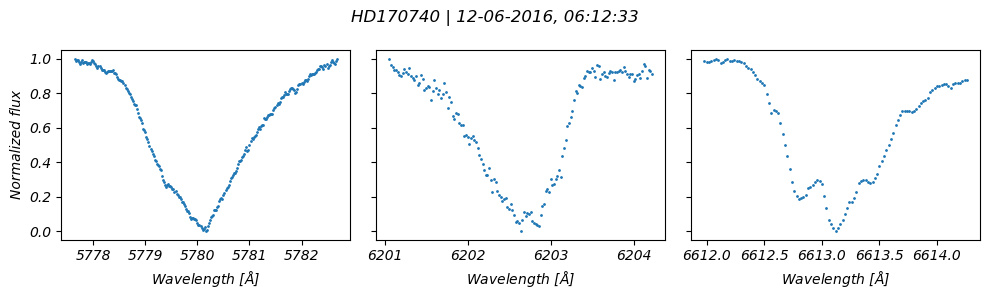

In [29]:
spec = FitsSpectrum('data/fits/HD170740/RED_564/HD170740_w564_n9_20160612_U.fits')
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
sample_dibs = np.array([5780, 6202, 6613])

dibs = spec.select_dibs()

for center, bounds in dibs.items():
    not_expected_dibs = np.abs(sample_dibs - center) > 1

    if np.all(not_expected_dibs):
        continue

    sample_idx = np.argwhere(~not_expected_dibs)[0][0]
    range_mask = (bounds[0] < spec.wavelength) & (spec.wavelength < bounds[1])
    wavelength = spec.wavelength[range_mask]
    flux = spec.flux[range_mask]
    flux = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
    
    axes[sample_idx].plot(wavelength, flux, '.', ms=2)
    axes[sample_idx].set_xlabel(r'Wavelength [$\AA$]')

    if sample_idx == 0:
        axes[sample_idx].set_ylabel('Normalized flux')

fig.suptitle(f'{spec.target} | {spec.format_obs_date()}')
fig.tight_layout()
fig.savefig('export/dibs_sample.pdf')


### Subset of HD170740

λ=5654.46-6686.46 [6654.80]: 100%|██████████| 219/219 [00:02<00:00, 97.61it/s] 

5780 \AA{} & 0.0384 & 1.29 & 1.823 & 5780.47 & 0.5476 & 0.8627 & 0.1527 \\
\hline
5797 \AA{} & 0.048 & 0.2704 & 0.5402 & 5796.75 & 0.07188 & 0.6922 & 0.02357 \\
& & & & 5797.05 & 0.1148 & 0.722 & 0.1514 \\
\hline
6613 \AA{} & 0.04178 & 0.5413 & 0.7932 & 6613.46 & 0.2299 & 0.8382 & \hspace{-3pt}-0.1029 \\
& & & & 6613.76 & 0.07251 & 0.02713 & \hspace{-3pt}-2 \\
& & & & 6613.14 & 0.04886 & 0.2947 & 0.1095 \\
\hline



Target,Observation date,Start [Å],End [Å],Center [Å],Width,Amplitude,Skew,RMSE,R2,FWHM [Å],EW [Å]
HD170740,"12-06-2016, 06:12:33",5777.93,5783.01,[5780.46774188],[0.54763034],[0.86271276],[0.15267152],0.0383985,0.98583,1.28957,1.82278
HD170740,"12-06-2016, 06:12:33",5795.91,5797.63,[5796.75296087 5797.05297491],[0.07187968 0.11484218],[0.69220528 0.72198275],[0.02356955 0.15144293],0.0480025,0.981845,0.270433,0.540173
HD170740,"12-06-2016, 06:12:33",6612.32,6614.64,[6613.45705925 6613.75707547 6613.13704197],[0.22987889 0.07251354 0.04885683],[0.83816628 0.0271347 0.29468005],[-0.1029458 -2. 0.10954104],0.041776,0.983941,0.541323,0.793207


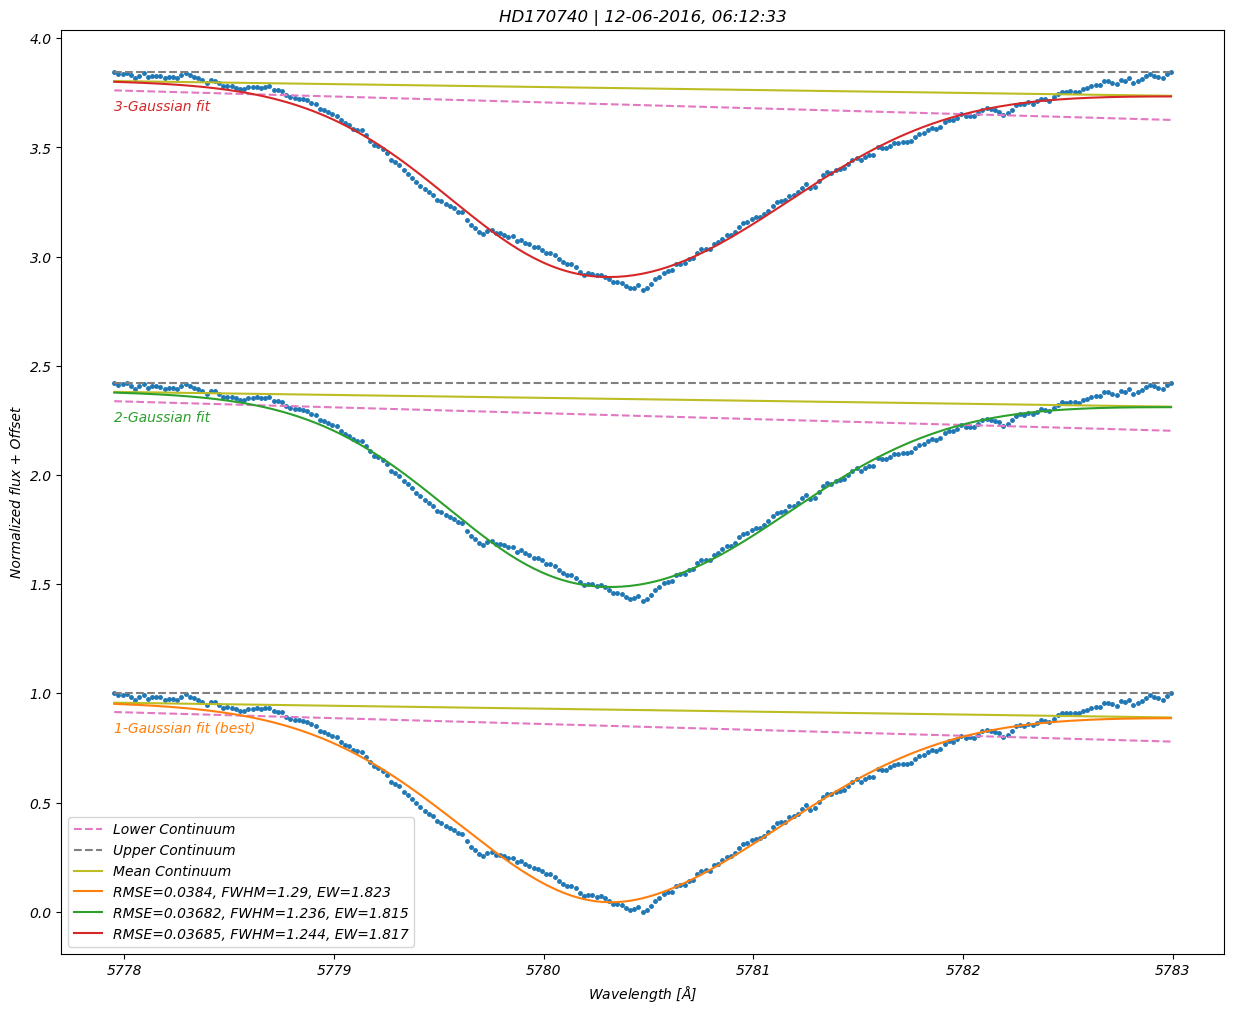

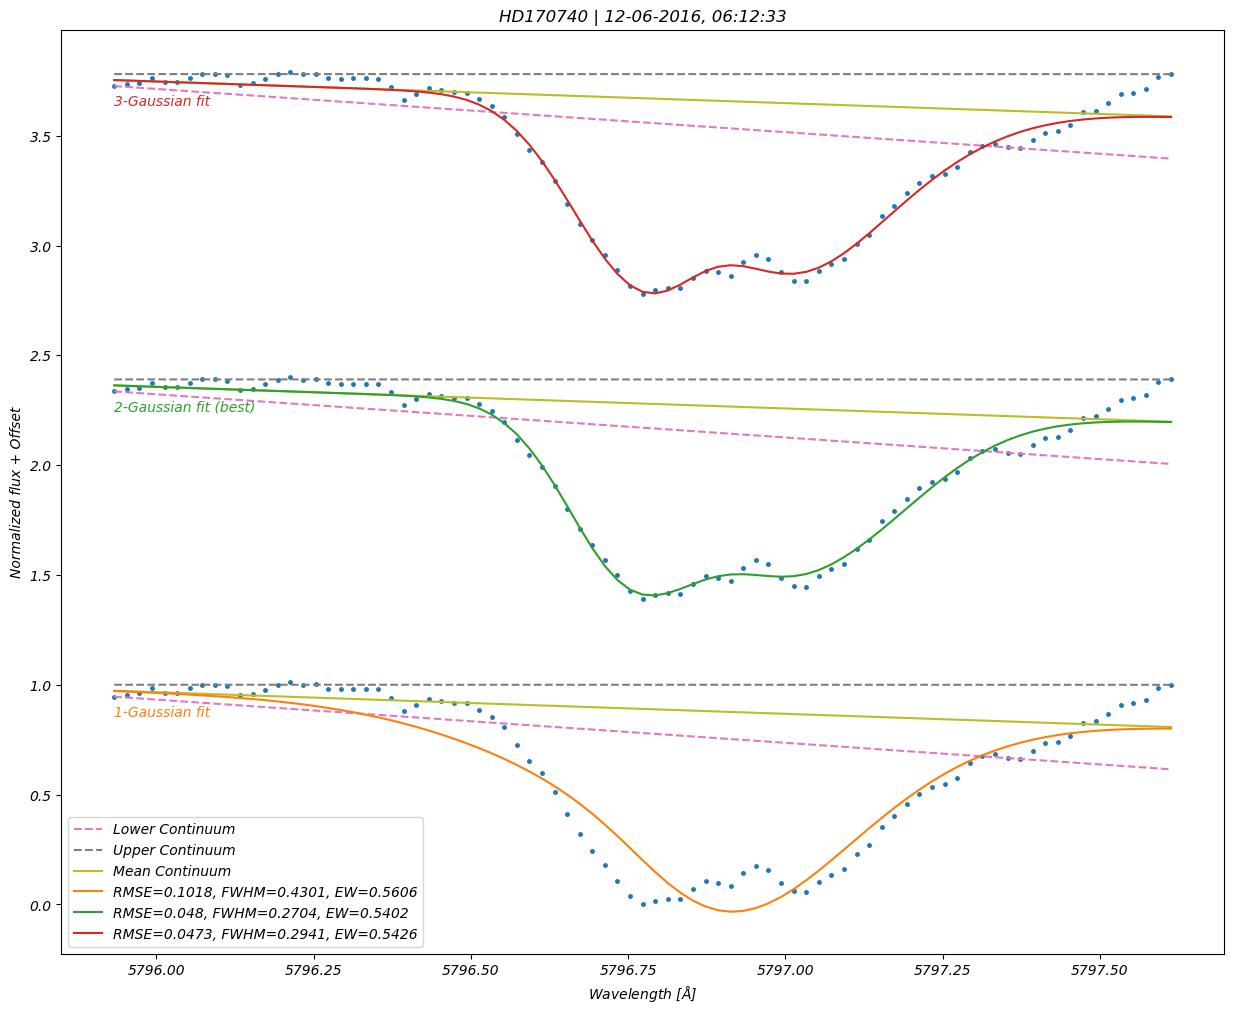

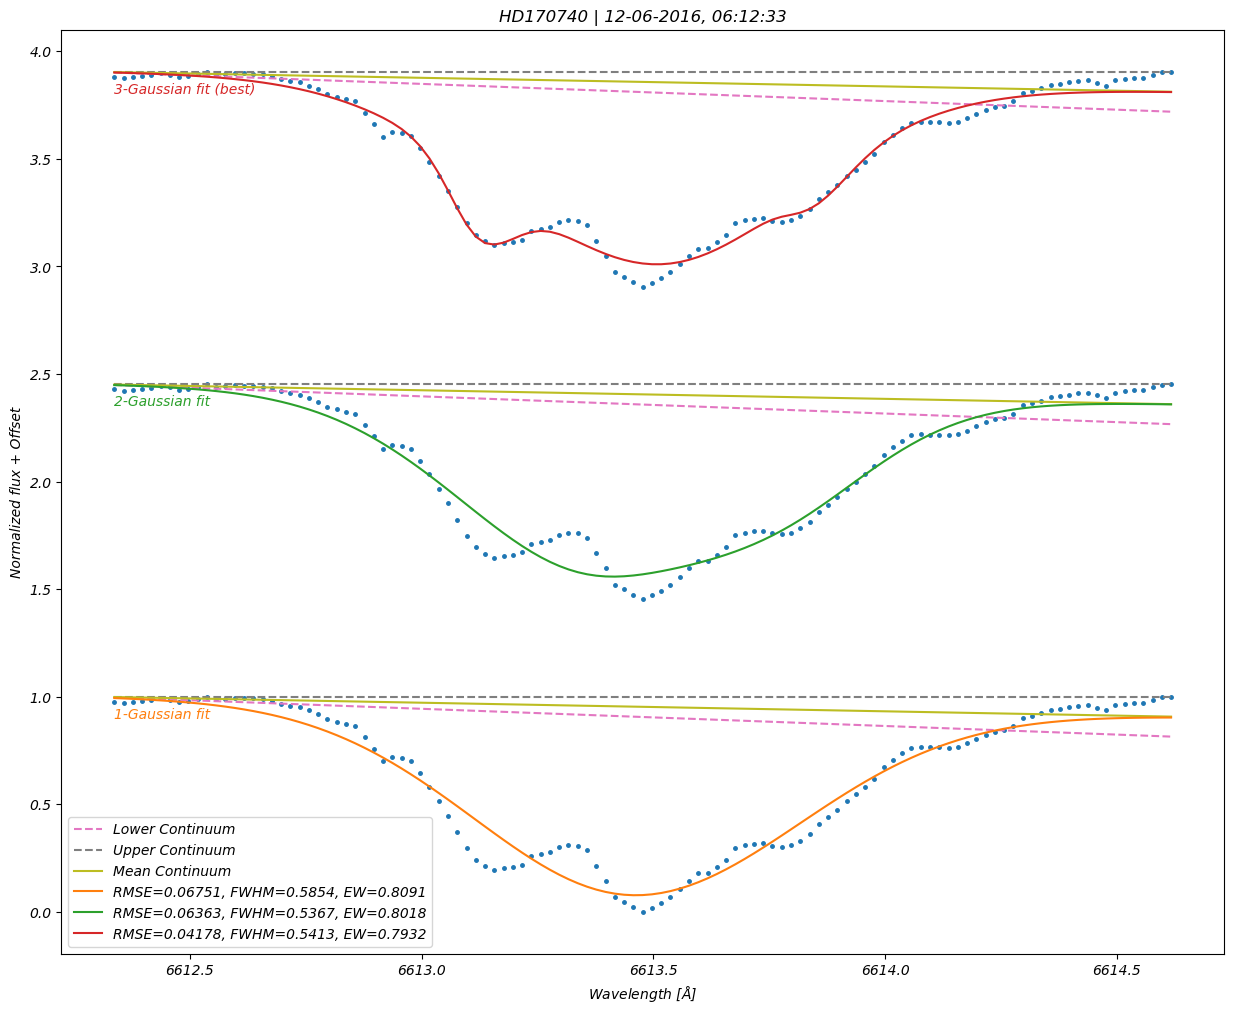

In [11]:
headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'R2', 'FWHM [Å]', 'EW [Å]']
table_data = []

latextable = fit_gaussian_for_subspectrum(
    FitsSpectrum('data/fits/HD170740/RED_564/HD170740_w564_n9_20160612_U.fits'),
    expected_dib_centers=[5780, 5797, 6613],
    create_figure=True,
    table_data=table_data
    # save_plot='5780_gauss.pdf'
    # show_error=True
)

print(latextable)

tabulate(table_data, ['Target', *headers], tablefmt='html')

### Subset of HD185859

λ=5654.48-6686.50 [6654.49]: 100%|██████████| 287/287 [00:01<00:00, 230.71it/s]

5780 \AA{} & 0.03636 & 1.296 & 1.911 & 5780.19 & 0.5504 & 0.906 & 0.1448 \\
\hline
5797 \AA{} & 0.03625 & 0.2648 & 0.5277 & 5796.59 & 0.09616 & 0.7129 & 0.2715 \\
& & & & 5796.77 & 0.1125 & 0.5403 & \hspace{-3pt}-0.3942 \\
\hline
6613 \AA{} & 0.03052 & 0.6479 & 0.8398 & 6613.19 & 0.04824 & 0.1794 & 0.1566 \\
& & & & 6612.93 & 0.2751 & 0.2074 & \hspace{-3pt}-2 \\
& & & & 6613.09 & 0.1343 & 0.1614 & 2 \\
\hline



Target,Observation date,Start [Å],End [Å],Center [Å],Width,Amplitude,Skew,RMSE,R2,FWHM [Å],EW [Å]
HD185859,"13-08-2016, 03:07:33",5777.75,5782.67,[5780.19367371],[0.55038699],[0.90602025],[0.14478974],0.036364,0.98824,1.29606,1.91148
HD185859,"13-08-2016, 03:07:33",5795.79,5797.35,[5796.59286361 5796.77285272],[0.09615848 0.11245549],[0.71286847 0.54032884],[ 0.27152628 -0.39420099],0.0362539,0.989672,0.264812,0.527709
HD185859,"13-08-2016, 03:07:33",6612.05,6614.33,[6613.18895298 6612.93244361 6613.09242975],[0.04823537 0.27512186 0.1342786 ],[0.17939007 0.20736573 0.16141791],[ 0.15662455 -2. 1.99999998],0.0305182,0.992994,0.647862,0.839811


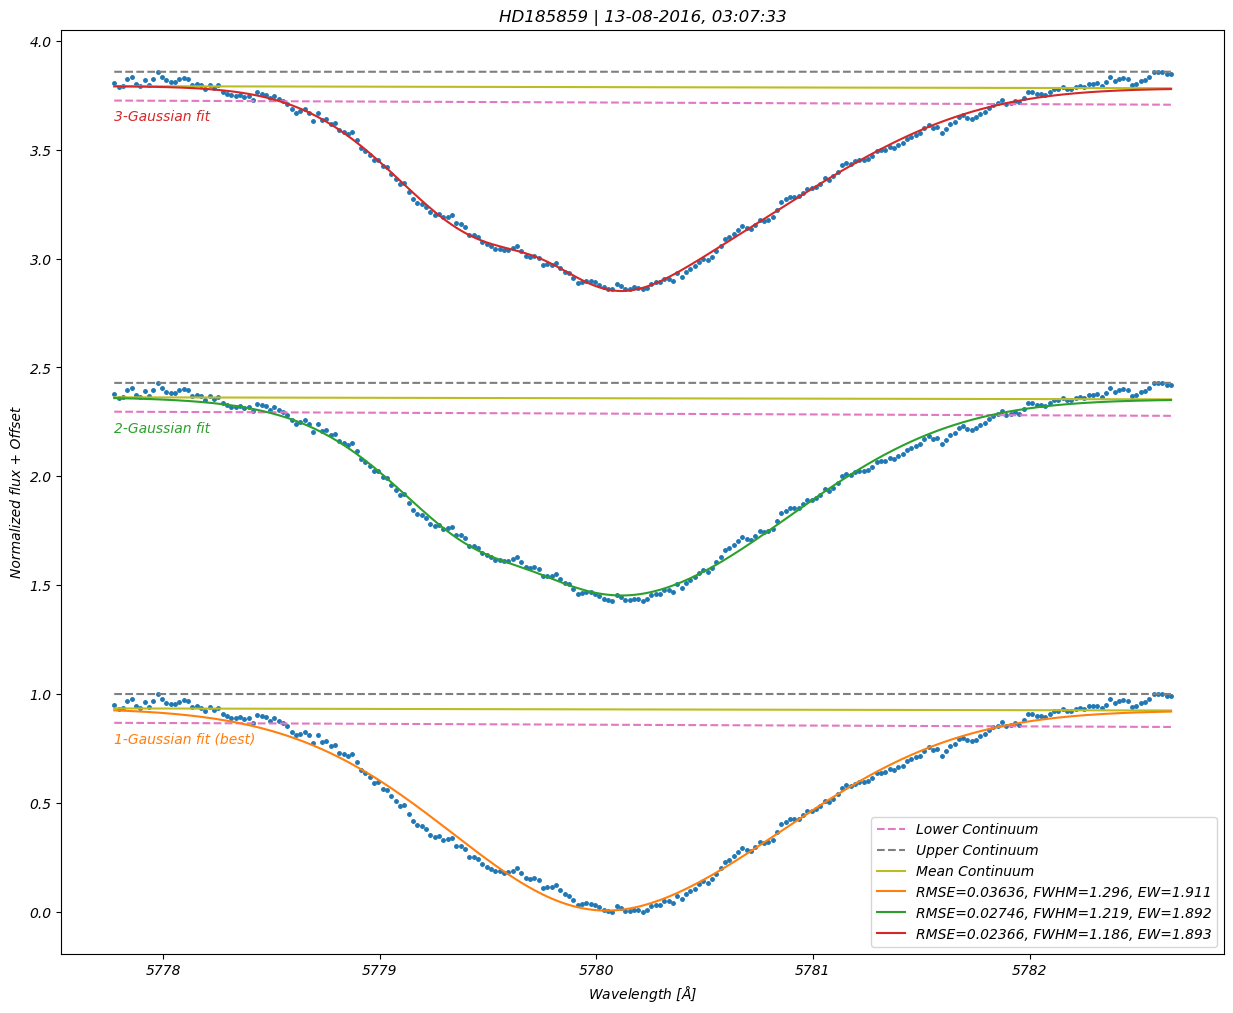

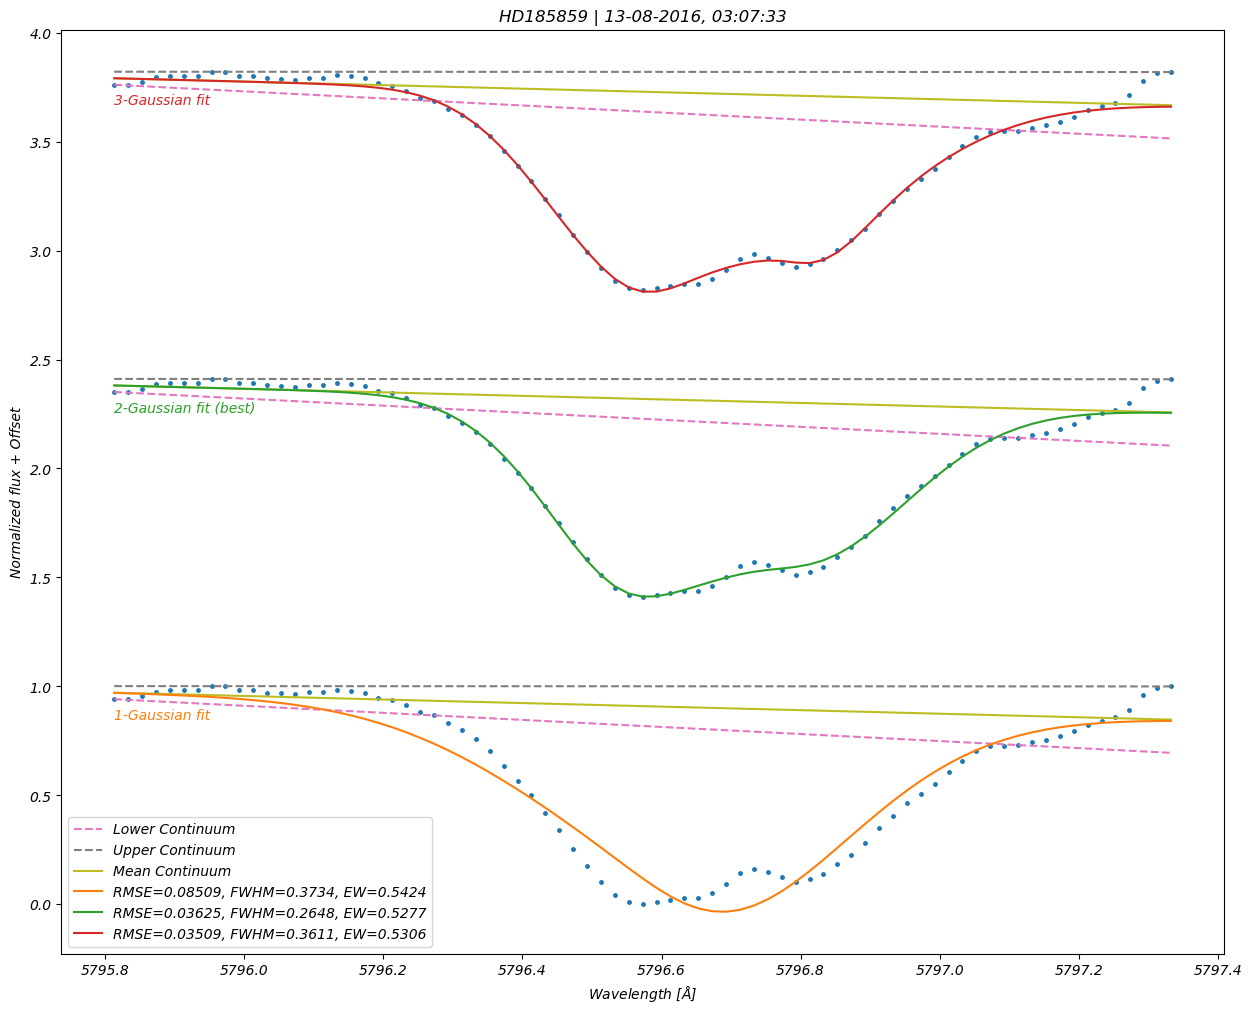

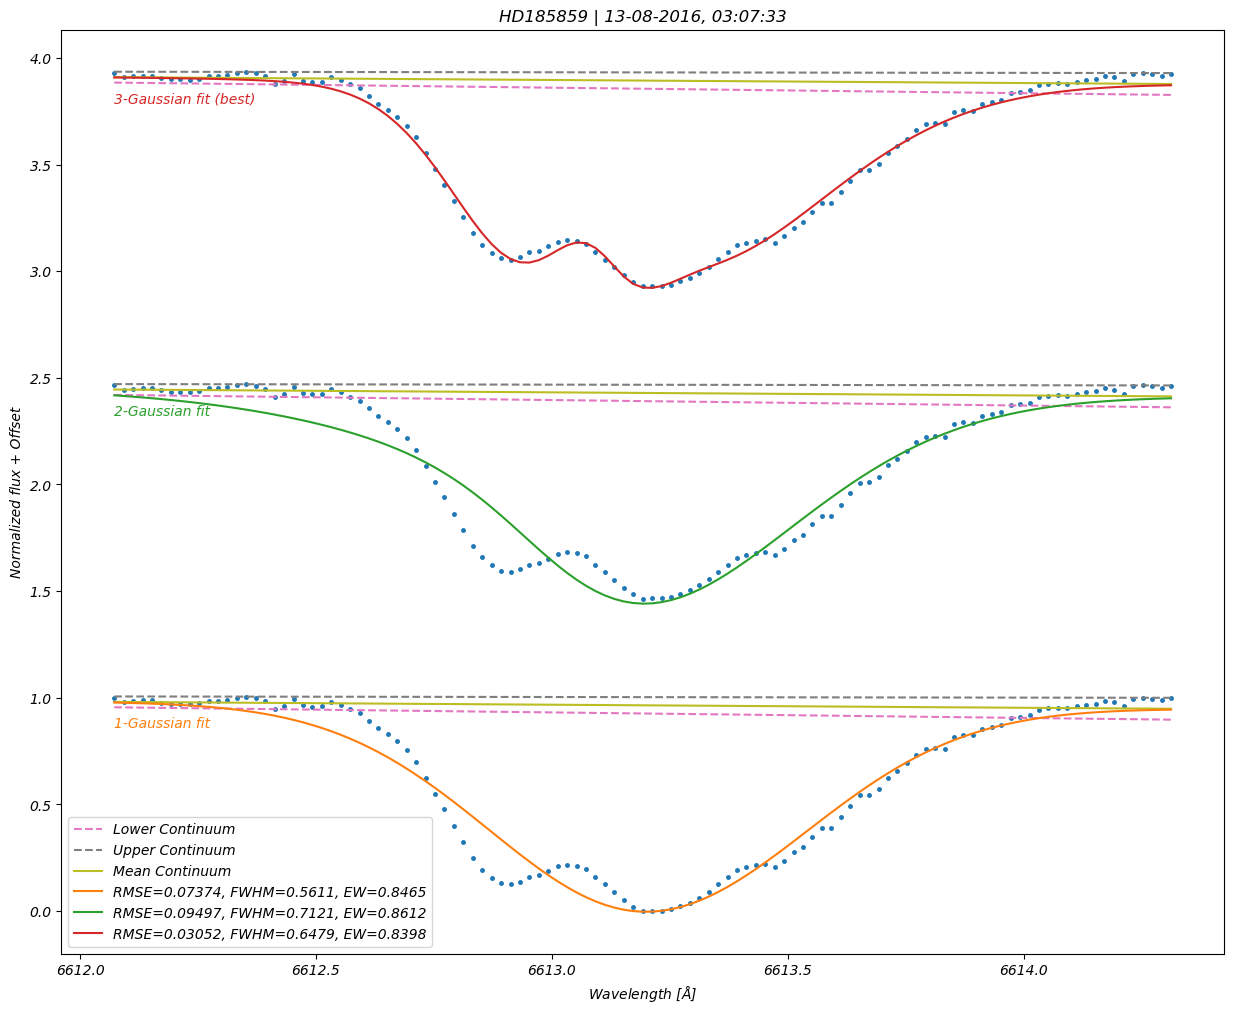

In [39]:
headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'R2', 'FWHM [Å]', 'EW [Å]']
table_data = []

print(fit_gaussian_for_subspectrum(
    FitsSpectrum('data/fits/HD185859/RED_564/HD185859_w564_n8_20160813_U.fits'),
    expected_dib_centers=[5780, 5797, 6613],
    create_figure=True,
    table_data=table_data
    # save_plot='5780_gauss.pdf'
    # show_error=True
))

tabulate(table_data, ['Target', *headers], tablefmt='html')

#### All of HD170740

In [37]:
_ = fit_gaussian_for_targets('HD158926', expected_dib_centers=dib_centers_all, export=True)

λ=6649.82-8544.26 [8530.39]: 100%|██████████| 962/962 [00:20<00:00, 46.91it/s] 
lambda Sco | 21-07-2015, 00:09:32: 100%|██████████| 1/1 [00:37<00:00, 37.24s/it]


### All DIBs of all selected targets

In [36]:
_ = fit_gaussian_for_targets(['HD147889', 'HD158926', 'HD170740', 'HD185859'], expected_dib_centers=dib_centers_all, export=True)

  0%|          | 0/4 [00:00<?, ?it/s]

λ=6649.86-8544.32 [8532.62]: 100%|██████████| 915/915 [00:19<00:00, 47.70it/s] 
HD185859 | 07-09-2016, 01:54:19: 100%|██████████| 4/4 [02:58<00:00, 44.74s/it]
